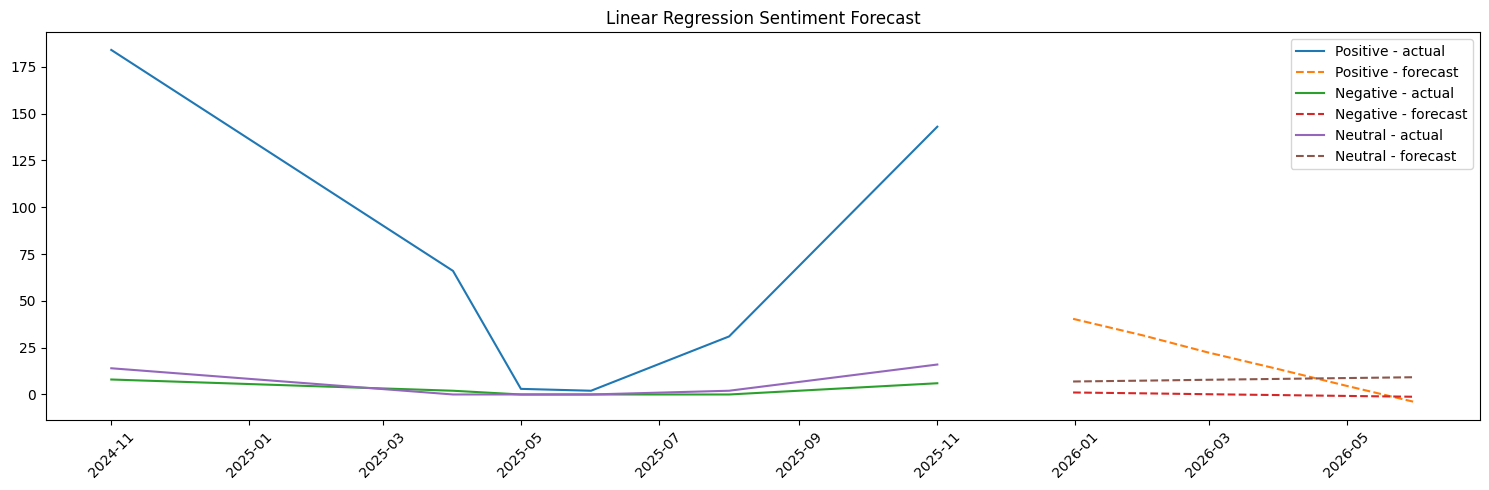

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsau4_5co/f27yjv38.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsau4_5co/u4csi66x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31642', 'data', 'file=/tmp/tmpsau4_5co/f27yjv38.json', 'init=/tmp/tmpsau4_5co/u4csi66x.json', 'output', 'file=/tmp/tmpsau4_5co/prophet_modeluyefh1on/prophet_model-20250415152150.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:21:50 - cmdstanpy - INFO - Chain [1] start processing
IN

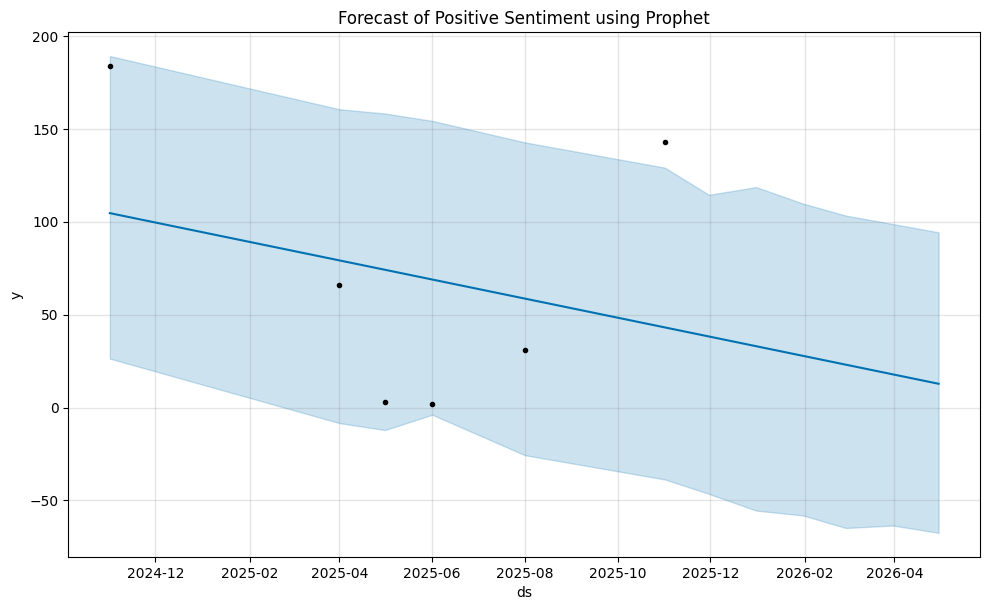

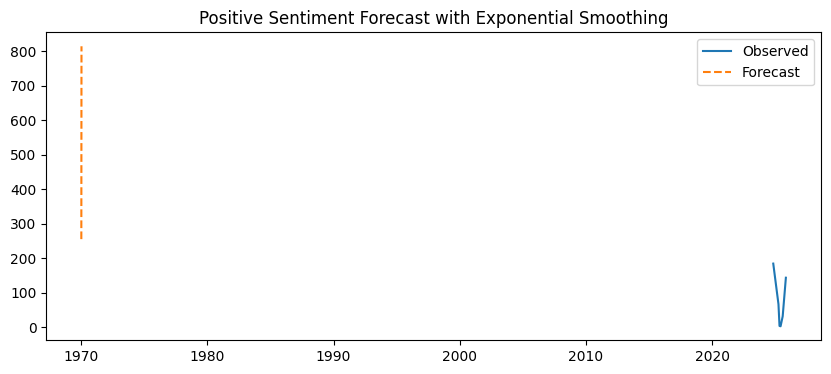

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

# Load and preprocess data
df = pd.read_csv("kochi_edutech_reviews_new.csv", encoding="ISO-8859-1")
df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
df.dropna(subset=["review", "date"], inplace=True)
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df.dropna(subset=["date"], inplace=True)
df["month"] = df["date"].dt.to_period("M")

# Sentiment Analysis
from textblob import TextBlob

def get_sentiment(score):
    if score > 0.1:
        return "Positive"
    elif score < -0.1:
        return "Negative"
    else:
        return "Neutral"

df["polarity"] = df["review"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df["sentiment"] = df["polarity"].apply(get_sentiment)

# Group data by month
monthly_sentiment = df.groupby(["month", "sentiment"]).size().unstack().fillna(0)
monthly_sentiment.index = monthly_sentiment.index.to_timestamp()

# ----- MODEL 1: Linear Regression Trend Prediction -----

# Prepare input
monthly_sentiment_lr = monthly_sentiment.copy()
monthly_sentiment_lr["month_num"] = range(len(monthly_sentiment_lr))

X = monthly_sentiment_lr[["month_num"]]
future_months = pd.DataFrame({"month_num": list(range(len(X), len(X)+6))})

plt.figure(figsize=(15, 5))
for sentiment in ["Positive", "Negative", "Neutral"]:
    y = monthly_sentiment_lr[sentiment]
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(future_months)

    # Plot
    plt.plot(monthly_sentiment_lr.index, y, label=f"{sentiment} - actual")
    plt.plot(pd.date_range(start=monthly_sentiment_lr.index[-1], periods=7, freq="M")[1:], y_pred, '--', label=f"{sentiment} - forecast")

plt.title("Linear Regression Sentiment Forecast")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ----- MODEL 2: Prophet Model (Facebook) -----

prophet_df = df.copy()
prophet_df = prophet_df[df["sentiment"] == "Positive"]
monthly_positive = prophet_df.groupby("month").size().reset_index(name="y")
monthly_positive["ds"] = monthly_positive["month"].dt.to_timestamp()
monthly_positive = monthly_positive[["ds", "y"]]

m = Prophet()
m.fit(monthly_positive)
future = m.make_future_dataframe(periods=6, freq="M")
forecast = m.predict(future)

# Plot forecast
fig1 = m.plot(forecast)
plt.title("Forecast of Positive Sentiment using Prophet")
plt.show()

# ----- MODEL 3: Exponential Smoothing -----

ts = monthly_sentiment["Positive"]
model_es = ExponentialSmoothing(ts, trend="add", seasonal=None)
fit_es = model_es.fit()
forecast_es = fit_es.forecast(6)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(ts, label="Observed")
plt.plot(forecast_es.index, forecast_es.values, label="Forecast", linestyle="--")
plt.title("Positive Sentiment Forecast with Exponential Smoothing")
plt.legend()
plt.show()
